# "Hello world" in `keras`, or comparing the `scikit-learn` and `keras` APIs

Neural networks have a somewhat deserved reputation among non-specialists for being not only computationally intensive to train and apply, and difficult to interpret (as if those weren't problems enough!), but also fiddly and tedious to build. 

This post is about demonstrating that the last criticism is no longer true: it's now possible to build a neural network model without worrying about the numerical details of floating point operations and linear algebra.

This is because of the arrival of _high-level_ neural network libraries. In this post we're going to compare one of these libraries, `keras`, to the most popular, feature-complete classical machine learning library used by Python people, `scikit-learn`. 

`keras` is a high level neural network library that wraps the Theano or TensorFlow backends, which handle the linear algebra and GPU details, with an API similar to `scikit-learn`'s. `scikit-learn` has a simple, coherent API built around `Estimator` objects. It is carefully designed and is a good description of machine learning workflow, and many engineers are already comfortable with it.

Let's get started by importing the libraries we'll need: `scikit-learn`, `keras` and some plotting features.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

Using Theano backend.


# Iris data

The famous iris dataset is a great way of demonstrating the API of a machine learning framework. In some ways it's the "Hello world" of machine learning.

The data is simple, and it's possible to get good accuracy with an extremely simple classifier. Using a neural network to classify it is using a sledghammer to crack a nut. This is great for the purposes of this article, in which want to focus entirely on the code required to get from data to working classifier, and not worry about the details of model design.

The iris dataset is built into many machine learning libraries. We like the copy in `seaborn`, because it comes as a labelled dataframe that can be visualized easily. Let's load it and look at the first 5 examples.

In [2]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


For each example (which is a flower) we have five pieces of data. Four are standard measurements of the flower's size (in centimeters), and the fifth is the species of iris.
There are three species: setosa, verscicolor and virginica. Our job is to build a classifier  that, given the two petal and two sepal measurements, can predict the species of an iris. Let's do a quick visualization before we start model building (always a good idea!)

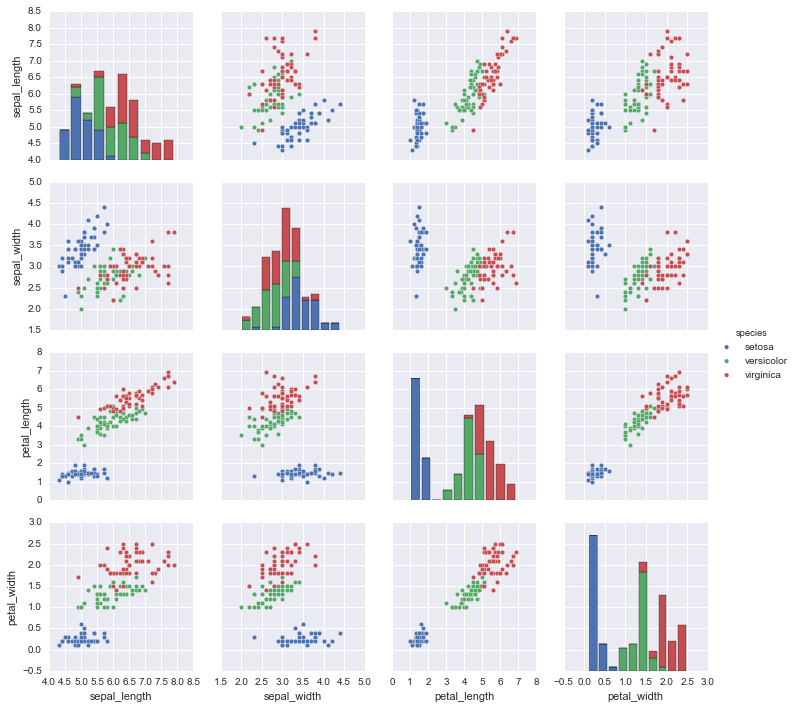

In [3]:
sns.pairplot(iris, hue='species');

# Munge and split the data for training and testing

First we need to pull the raw data out of the `iris` dataframe. We'll hold the petal and sepal data in an array `X` and the species encoded as numbers `0`, `1` and `2` in an array `y`. (That encoding of species is done here using `scikit-learn`'s `LabelEncoder`, but would be easy enough to do by hand.

In [4]:
X = iris.values[:, 0:4]
y = iris.values[:, 4]

Now we split `X` and `y` in half. As is standard in supervised machine learning, we'll train with half the data, and measure the performance of our model with the other half. This is simple to do by hand, but is built into scikit-learn as the `train_test_split()` function.

In [5]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.5, random_state=0)

# Train a scikit-learn classifier

We'll train a logisitic regression classifier. Doing this, with built-in hyper-paramter cross validation, is one-liner in scikit-learn. Like all scikit-learn `estimator` objects, a `LogisticRegressionCV` classifier has a `.fit()` method that takes care of the gory numerical details of learning model parameters that best fit the training data. So that method is all we need to do:

In [6]:
lr = LogisticRegressionCV()
lr.fit(train_X, train_y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

# Assess the classifier using accuracy

Now we can measure the fraction of of the test set the trained classifer classifies correctly. This is called accuracy.

In [7]:
pred_y = lr.predict(test_X)
print("Test fraction correct (Accuracy) = {:.2f}".format(lr.score(test_X, test_y)))

Test fraction correct (Accuracy) = 0.83


# Now do something very similar with Keras

scikit-learn makes building a classifier very simple:
 - one line to instantiate the classifier
 - one line to train it
 - and one line to measure its performance
 
It's only a little bit more complicated in keras.

First a bit of data-munging: scikit-learn's classifiers are happy to accept string labels, e.g. `"setosa"`. But `keras` requires that the labels be one-hot-encoded. This means we need to convert data that looks like

```
setosa
versicolor
setosa
virginica
...
```

to a table that looks like

```
setosa versicolor virginica
     1          0         0
     0          1         0
     1          0         0
     0          0         1
```

There are lots of ways of doing this. It's not hard to do by hand. Because this isn't the focus of this article, we'll do it the quick way, using `scikit-learn`

In [8]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False)
train_y_ohe = vec.fit_transform([{'species': y_i} for y_i in train_y])
test_y_ohe = vec.fit_transform([{'species': y_i} for y_i in test_y])                             

# Build the neural network model

Building the model is the only aspect of using keras that is substantially more code than in scikit-learn. 

keras is a neural network library, so, while you are constrained by the number of features and number of classes in your data, all other aspects of model structure are up to you. This means that instaniating the classifier, which was a one-liner in `scikit-learn`, in now more work.

In this case, we'll build an extremely simple network: 4 features in the input layer (the four flower measurements), 3 classes in the ouput layer (corresponding to the 3 species), and 16 hidden units because (from the point of view of a GPU, 16 is a round number!)

In [9]:
model = Sequential()
model.add(Dense(16, input_shape=(4,)))
model.add(Activation('sigmoid'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

But now we've instantiated the `keras` model, we have an object whose API is almost identical to a classifier in `scikit-learn`. In particular, it has `.fit()` and `.predict()` methods. Let's `fit`:

In [10]:
model.fit(train_X, train_y_ohe, verbose=0, batch_size=1)

For basic use, the only syntactic API difference between a compiled keras model and a sklearn classifier is that keras's equivalent of the sklearn `.score()` method is called `.evaluate()`. By default it returns whatever loss function you set when you compiled the model, but we can ask it to return the accuracy too. In which case the second number it returns is exactly what you'd get from `.score()` in sklearn.

In [11]:
model.evaluate(test_X, test_y_ohe, show_accuracy=True, verbose=0)

[0.14450973272323608, 0.97333333333333338]